In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import timedelta
from sklearn.decomposition import PCA
import ace_tools_open as tools

DATA_PATH = "Data/"

# Load Data
clients_df = pd.read_excel(f"{DATA_PATH}clients.xlsx")
transactions_df = pd.read_excel(f"{DATA_PATH}transactions.xlsx")
actions_df = pd.read_excel(f"{DATA_PATH}actions.xlsx")

In [34]:
# Convert dates to datetime
actions_df["action_start_date"] = pd.to_datetime(actions_df["action_start_date"])
actions_df["action_end_date"] = pd.to_datetime(actions_df["action_end_date"])

# Merge transactions with actions to assign events to transactions
transactions_df_ = transactions_df.merge(actions_df, on="client_id", how="left")
transactions_df_["transaction_date"] = pd.to_datetime(transactions_df_["transaction_date"])

In [35]:

period = timedelta(days=3*30)  # Approximate 3 months as 90 days

def assign_event_period(row):
    """Classify transactions as before, after, or during an event based on a 6-month window."""
    if row["transaction_date"] < row["action_start_date"] - period:
        return "else"
    elif row["transaction_date"] > row["action_end_date"] + period:
        return "else"
    elif row["action_start_date"] - period <= row["transaction_date"] < row["action_start_date"]:
        return "pre-event"
    elif row["action_end_date"] < row["transaction_date"] <= row["action_end_date"] + period:
        return "post-event"
    else:
        return "during"

In [36]:
# Ensure transactions are grouped by event category and client
category_clusters = {}
category_data = pd.DataFrame()

# k for K-Means for each cathegory - obtained by visually looking at elbow graph
k_optimal_list = [4, 5, 4, 3, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3]

In [37]:
transactions_df_['client_is_invited'] = transactions_df_['client_is_invited'].fillna(0)

How to clusterize the clients here : 

- **Frequency of purchases** (number of transactions per period) with variables **'product_quantity_during', 'product_quantity_post-event', 'product_quantity_pre-event', 'before_after_quantity_ratio_'**
- **Engagement with events** (attendance rate) with variable **attendance_ratio_during**
- Prioritizes Clients with **Strong Revenue Uplift** with variables **'gross_amount_euro_during', 'gross_amount_euro_post-event', 'gross_amount_euro_pre-event', 'before_after_ratio_euro_'**

Business Engagement


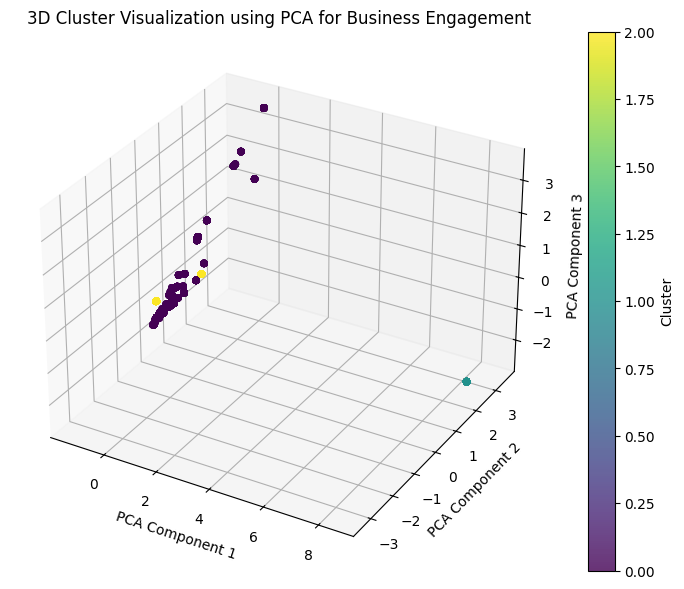

Social Gathering


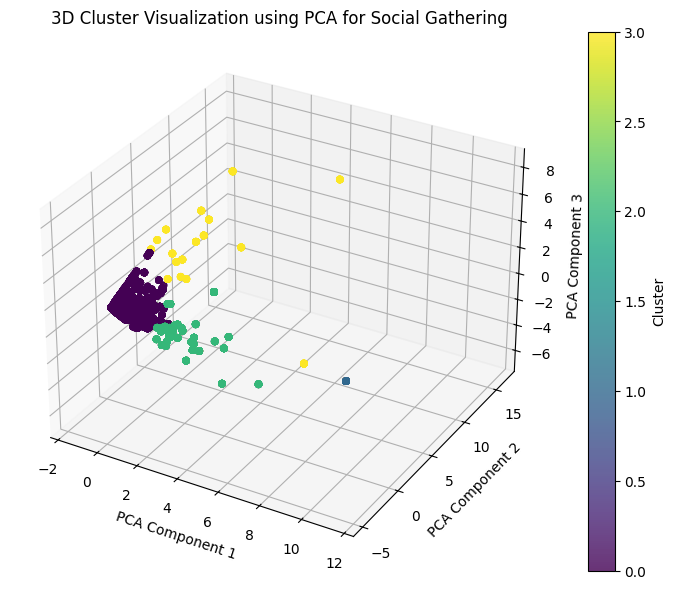

Exclusive Offer


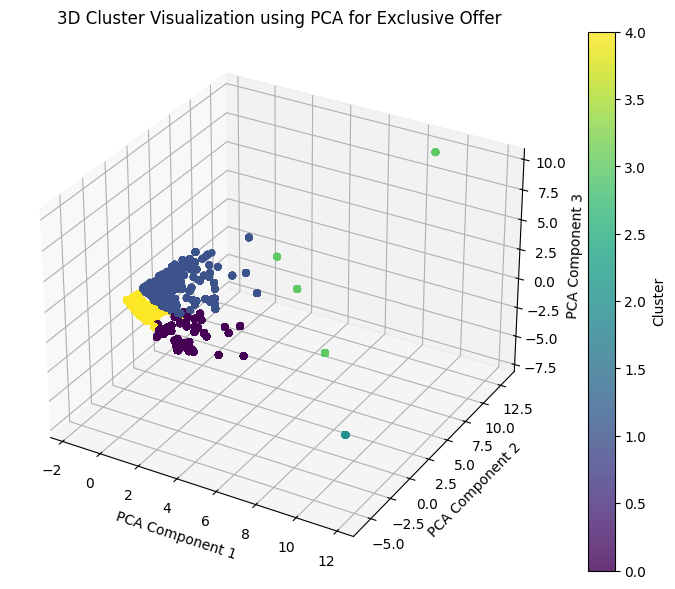

Holiday Celebration


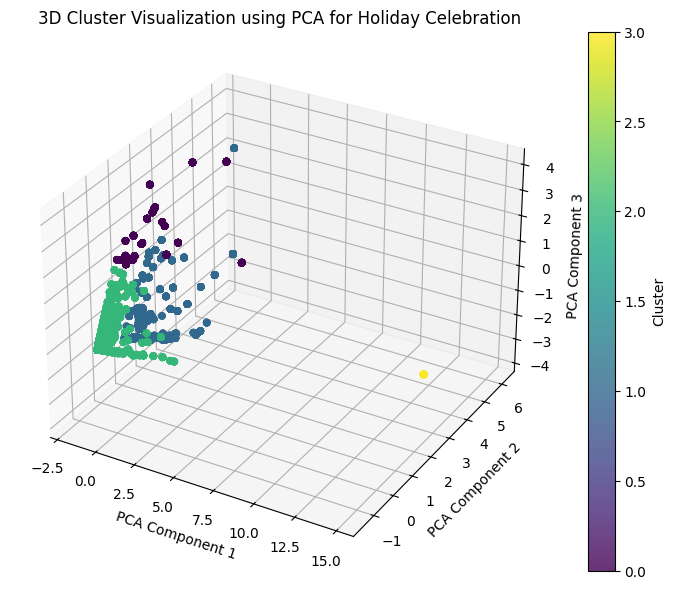

Lunar New Year Celebration


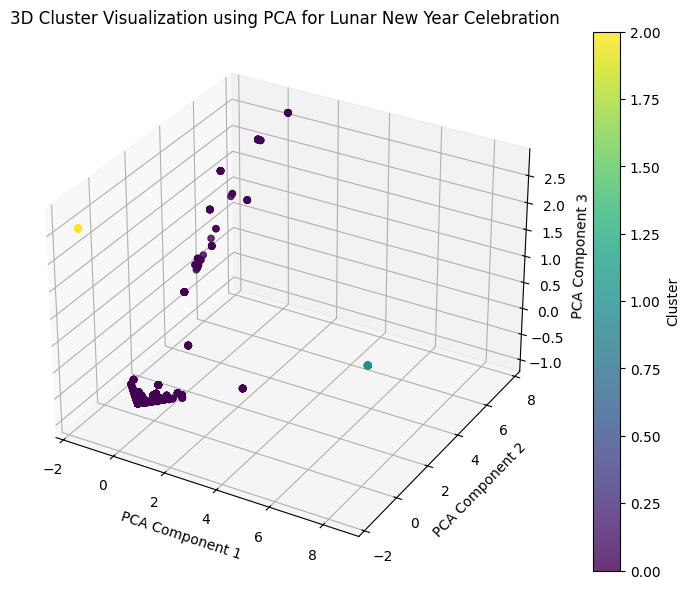

Trunk Show Event


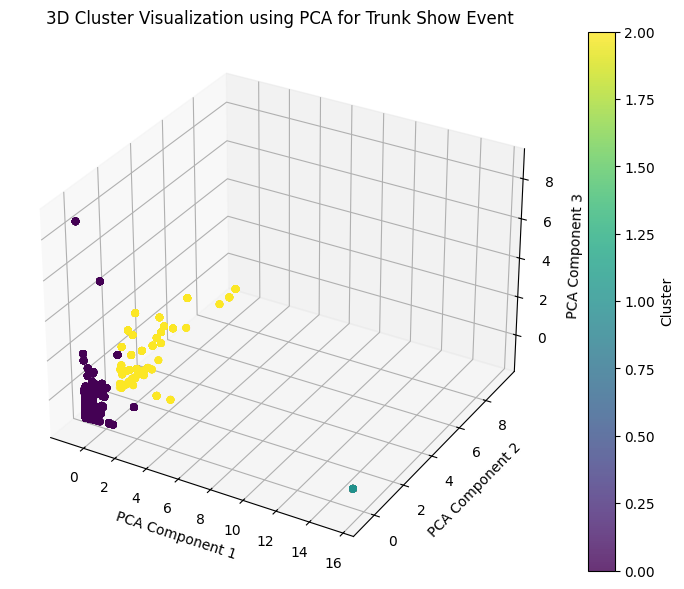

Fur Collection Rotation


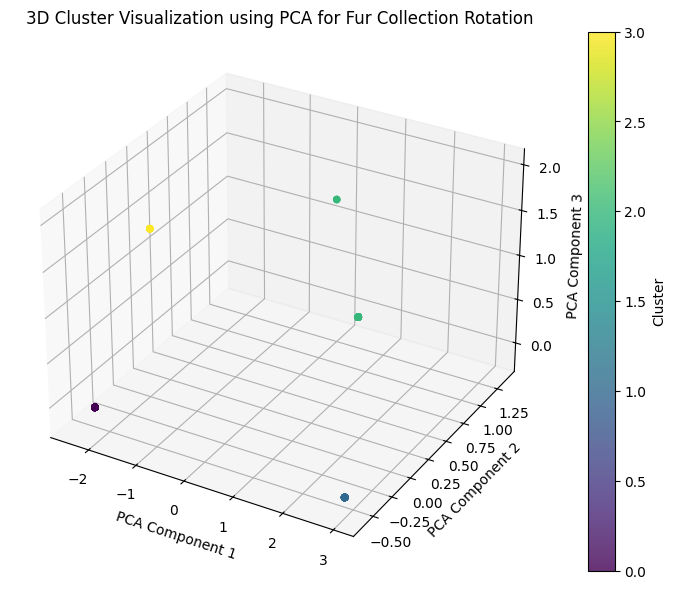

Miscellaneous Social Gathering


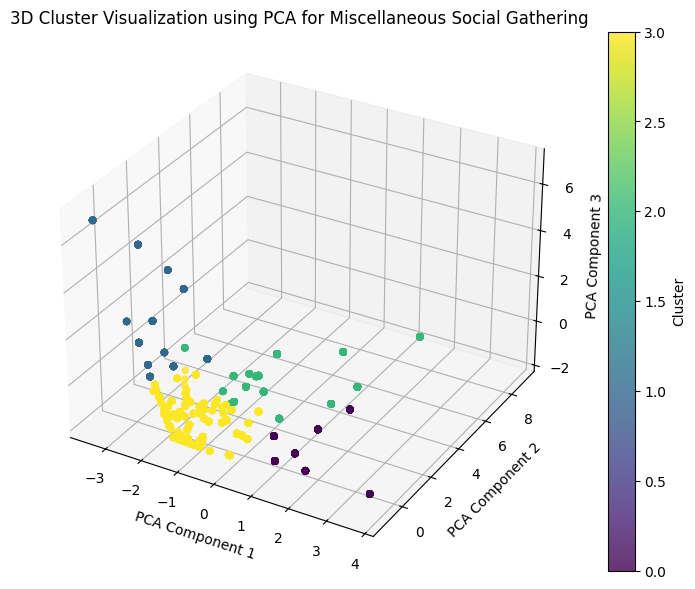

Outdoor Event


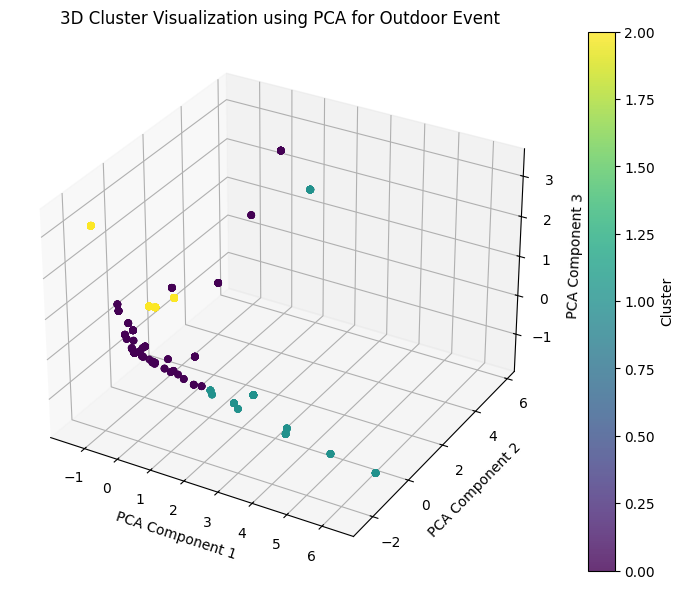

Luxurious Fur Showcase


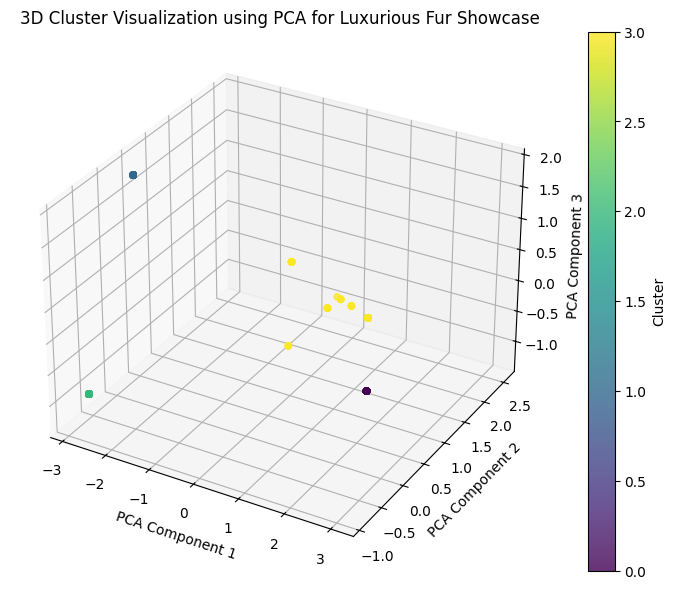

Exclusive Preview


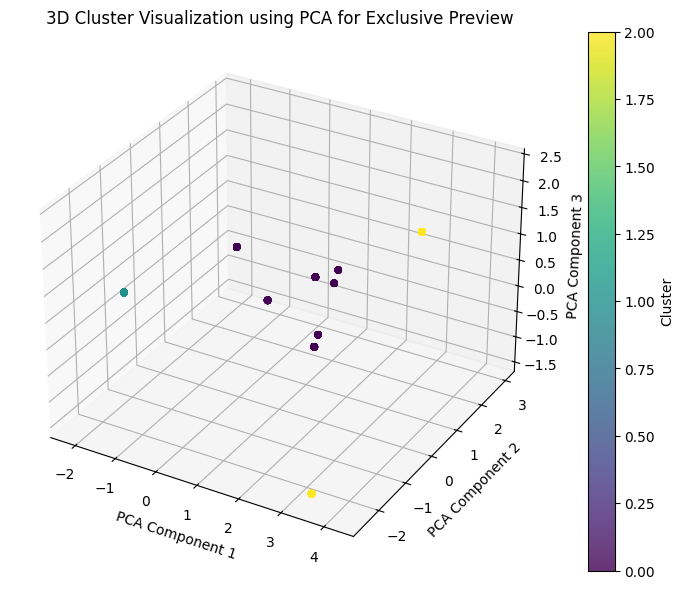

Exclusive Client Days


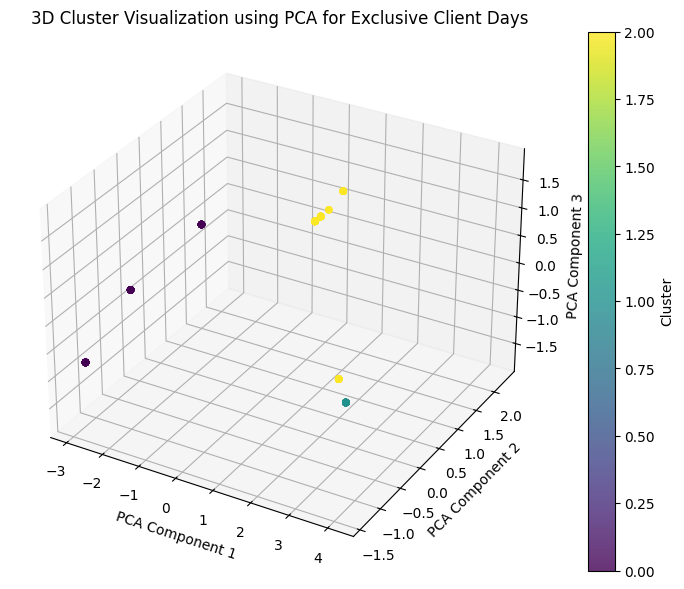

Back-to-School Promotion


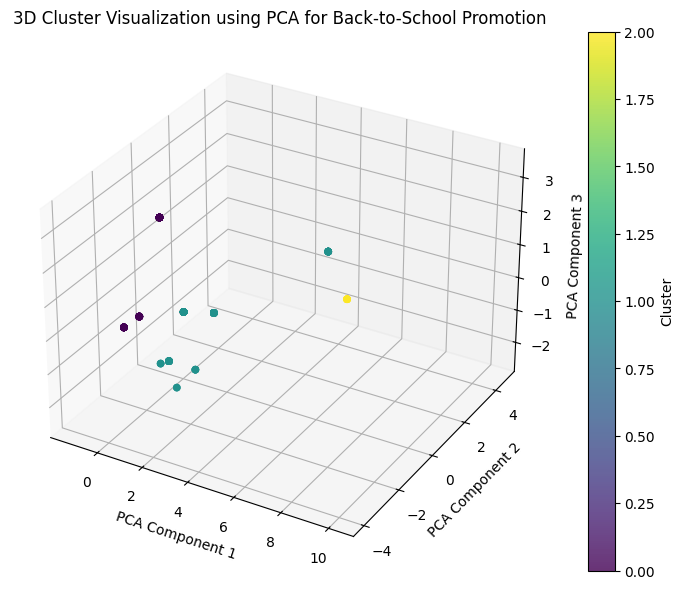

Live Presentation


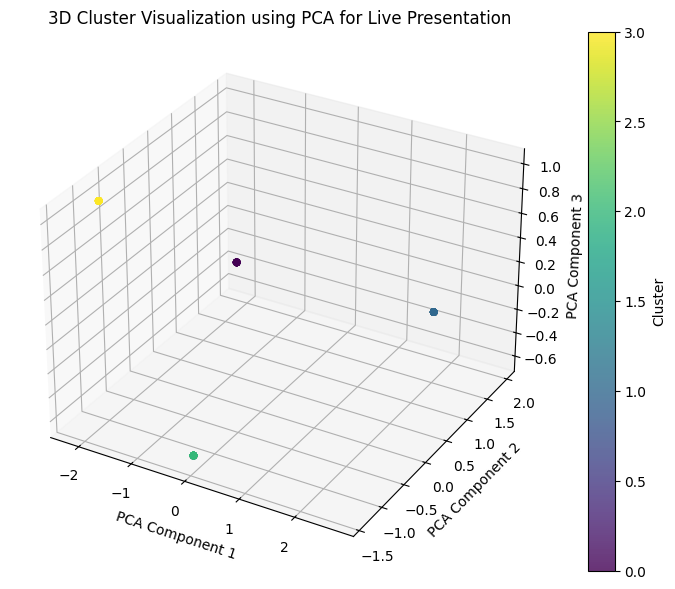

In [38]:
# Loop through each unique event category and apply clustering
for i, category in enumerate(transactions_df_["action_label"].unique()):
    if category is np.NaN:
        continue

    print(category)
    k_optimal = k_optimal_list[i - 1]

            ############################################################
            ############### --- FOR CLIENTS INVITED --- ################

    category_data = transactions_df_.copy()[transactions_df_["client_is_invited"] == 1]
    category_data = category_data[category_data["action_label"] == category]
    
    # Apply the function
    category_data["event_period"] = category_data.apply(assign_event_period, axis=1)

    # Aggregate sales and product quantity per customer before/after event
    sales_agg = category_data.groupby(["client_id", "event_period"]).agg(
        gross_amount_euro=("gross_amount_euro", "sum"),  # Total sales
        product_quantity=("product_quantity", "sum"),  # Total quantity of products purchased
        
    ).unstack().fillna(0)

    if "during" not in sales_agg["gross_amount_euro"].columns:
        sales_agg[("gross_amount_euro", "during")] = 0
    if "during" not in sales_agg["product_quantity"].columns:
        sales_agg[("product_quantity", "during")] = 0

    sales_agg["before_after_ratio_euro"] = np.where(
        sales_agg["gross_amount_euro"]['pre-event'] > 0, 
        (sales_agg["gross_amount_euro"]['post-event'] + sales_agg.get("gross_amount_euro_during", 0)) / 
        (sales_agg["gross_amount_euro"]['pre-event'] + sales_agg["gross_amount_euro"]['during']), 
        
        np.where(
            (sales_agg["gross_amount_euro"]['post-event'] + sales_agg["gross_amount_euro"]['during']) > 0, 
            ((sales_agg["gross_amount_euro"]['post-event'] + sales_agg["gross_amount_euro"]['during']) // 500),  
            0  
        )
    )

    # Also Compute Before/After Product Quantity Ratio
    sales_agg["before_after_quantity_ratio"] = np.where(
        sales_agg["product_quantity"]['pre-event'] > 0, 
        (sales_agg["product_quantity"]['post-event'] + sales_agg["product_quantity"]['during']) / 
        (sales_agg["product_quantity"]['pre-event'] + sales_agg["product_quantity"]['during']), 
        
        np.where(
            (sales_agg["product_quantity"]['post-event'] + sales_agg["product_quantity"]['during']) > 0, 
            ((sales_agg["product_quantity"]['post-event'] + sales_agg["product_quantity"]['during']) // 1),  
            0  
        )
    )

    # Compute attendance ratio per client and event period
    attendance_agg = category_data.groupby(["client_id", "event_period"])["client_is_present"].mean().unstack().fillna(0)

    # Flatten the multi-index columns
    sales_agg.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in sales_agg.columns]
    
    # Reset index to bring client_id back as a column
    sales_agg = sales_agg.reset_index()

    # Rename the attendance ratio column for clarity
    attendance_agg.columns = [f"attendance_ratio_{col}" for col in attendance_agg.columns]
    if 'attendance_ratio_during' not in attendance_agg.columns:
        attendance_agg['attendance_ratio_during'] = 0

    # Merge attendance ratio with the existing sales aggregation dataframe
    sales_agg = sales_agg.merge(attendance_agg['attendance_ratio_during'], on="client_id", how="left")

    # We remove c55911932 c81328703 because they are outliers and VVIP clients
    clients_to_drop = ["c55911932", "c81328703"]
    sales_agg = sales_agg[~sales_agg["client_id"].isin(clients_to_drop)]

    # Merge with client information
    final_df = sales_agg.merge(transactions_df, on="client_id", how="inner")

    # Feature Selection for Clustering
    features = final_df[['gross_amount_euro_during', 'gross_amount_euro_post-event', 'gross_amount_euro_pre-event',
                        'product_quantity_during', 'product_quantity_post-event', 'product_quantity_pre-event',
        'before_after_ratio_euro_', 'before_after_quantity_ratio_', 'attendance_ratio_during'
        ]]
    # Standardize features
    scaler = StandardScaler()
    category_features_scaled = scaler.fit_transform(features)

    kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
    final_df["Cluster"] = kmeans.fit_predict(category_features_scaled)

    # Step 1: Reduce dimensionality using PCA
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)

    features_pca_2d = pca_2d.fit_transform(category_features_scaled)
    features_pca_3d = pca_3d.fit_transform(category_features_scaled)

    # Step 2: Create a DataFrame for visualization
    final_df["PCA1"] = features_pca_2d[:, 0]
    final_df["PCA2"] = features_pca_2d[:, 1]
    final_df["PCA3"] = features_pca_3d[:, 2]

    # Step 3: 3D Scatter Plot
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(final_df["PCA1"], final_df["PCA2"], final_df["PCA3"], c=final_df["Cluster"], cmap="viridis", alpha=0.8)

    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")
    ax.set_title(f"3D Cluster Visualization using PCA for {category}")
    plt.colorbar(scatter, ax=ax, label="Cluster")
    plt.show()

    ##############################################################
    ############### --- FOR CLIENTS UNINVITED --- ################

    category_data = transactions_df_.copy()[transactions_df_["client_is_invited"] == 0]
    
            ###             ---  TO DO  ---            ### 

    # Store results in a dictionary
    category_clusters[category] = final_df

In [39]:
category_clusters.keys()

dict_keys(['Business Engagement', 'Social Gathering', 'Exclusive Offer', 'Holiday Celebration', 'Lunar New Year Celebration', 'Trunk Show Event', 'Fur Collection Rotation', 'Miscellaneous Social Gathering', 'Outdoor Event', 'Luxurious Fur Showcase', 'Exclusive Preview', 'Exclusive Client Days', 'Back-to-School Promotion', 'Live Presentation'])

**All the actions possible for our brand:**
- Business Engagement
- Social Gathering
- Exclusive Offer 'Holiday Celebration
 - Lunar New Year Celebration
- Trunk Show Event
- Fur Collection Rotation 
- Miscellaneous Social Gathering
- Outdoor Event 
- Luxurious Fur Showcase
- Exclusive Preview 
- Exclusive Client Days
- Back-to-School Promotion Live Presentation

# Get the capacity of people to be invited by evenement

In [40]:
transactions_df_.groupby("action_label")["client_is_present"].sum().reset_index()

# Count the number of unique events per action_label
event_counts = transactions_df_.groupby("action_label")["action_id"].nunique().reset_index()
event_counts.rename(columns={"action_id": "unique_event_count"}, inplace=True)

# Compute total attendance per action_label
total_attendance = transactions_df_.groupby("action_label")["client_is_present"].sum().reset_index()

# Merge to get the total attendance and number of events per action_label
attendance_ratio_df = total_attendance.merge(event_counts, on="action_label")

# Compute the mean attendance ratio per event for each action_label
attendance_ratio_df["mean_attendance_ratio"] = attendance_ratio_df["client_is_present"] / attendance_ratio_df["unique_event_count"]
attendance_ratio_df["mean_attendance_ratio"] = attendance_ratio_df["mean_attendance_ratio"].round().astype(int)

# Sort the dataframe by mean_attendance_ratio in descending order
attendance_ratio_df_sorted = attendance_ratio_df.sort_values(by="mean_attendance_ratio", ascending=False)

attendance_ratio_df_sorted

,action_label,client_is_present,unique_event_count,mean_attendance_ratio
4,Exclusive Preview,821.0,1,821
6,Holiday Celebration,10428.0,21,497
13,Trunk Show Event,8253.0,26,317
12,Social Gathering,14710.0,56,263
7,Live Presentation,178.0,1,178
5,Fur Collection Rotation,135.0,1,135
10,Miscellaneous Social Gathering,2766.0,21,132
1,Business Engagement,3298.0,26,127
3,Exclusive Offer,21728.0,197,110
9,Luxurious Fur Showcase,392.0,8,49


In [41]:
# Convert the dataframe into a dictionary with action_label as keys and mean_attendance_ratio as values
attendance_dict = dict(zip(attendance_ratio_df_sorted["action_label"], attendance_ratio_df_sorted["mean_attendance_ratio"]))

# Display the dictionary
attendance_dict

{'Exclusive Preview': 821,
 'Holiday Celebration': 497,
 'Trunk Show Event': 317,
 'Social Gathering': 263,
 'Live Presentation': 178,
 'Fur Collection Rotation': 135,
 'Miscellaneous Social Gathering': 132,
 'Business Engagement': 127,
 'Exclusive Offer': 110,
 'Luxurious Fur Showcase': 49,
 'Exclusive Client Days': 46,
 'Outdoor Event': 32,
 'Lunar New Year Celebration': 23,
 'Back-to-School Promotion': 4}

In [42]:
# Round numerical values to 2 decimal places for better display
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 40)

for category in category_clusters:

    max_capacity = attendance_dict[category]

    # Compute summary statistics for each cluster
    cluster_summary = category_clusters[category].groupby("Cluster").agg({
    "gross_amount_euro_pre-event": ["mean"],
    "gross_amount_euro_post-event": ["mean"],
    "before_after_quantity_ratio_": ["mean", "min", "max"],
    "before_after_ratio_euro_": ["mean", "min", "max"],
    "attendance_ratio_during": ["mean"],
    "client_id": "nunique",  # Count unique client IDs per cluster
    "Cluster": "count"  # Count of clients in each cluster
    }).rename(columns={"gross_amount_euro_pre-event": "pre-sales",
                       "gross_amount_euro_post-event": "post-sales",
                       "before_after_quantity_ratio_": "quantity-ratio",
                       "before_after_ratio_euro_": "sales-ratio",
                       "Cluster": "transactions_count",
                        "client_id" : "client_count"})

    cluster_summary = cluster_summary.round(2)

    tools.display_dataframe_to_user(name=f"Cluster Summary for {category} with max capacity of {max_capacity}", dataframe=cluster_summary)

Cluster Summary for Business Engagement with max capacity of 127


Cluster Summary for Social Gathering with max capacity of 263


Cluster Summary for Exclusive Offer with max capacity of 110


Cluster Summary for Holiday Celebration with max capacity of 497


Cluster Summary for Lunar New Year Celebration with max capacity of 23


Cluster Summary for Trunk Show Event with max capacity of 317


Cluster Summary for Fur Collection Rotation with max capacity of 135


Cluster Summary for Miscellaneous Social Gathering with max capacity of 132


Cluster Summary for Outdoor Event with max capacity of 32


Cluster Summary for Luxurious Fur Showcase with max capacity of 49


Cluster Summary for Exclusive Preview with max capacity of 821


Cluster Summary for Exclusive Client Days with max capacity of 46


Cluster Summary for Back-to-School Promotion with max capacity of 4


Cluster Summary for Live Presentation with max capacity of 178


# Streamlit application for AI generation of guest list for different events

In [43]:
# Initialize an empty dictionary to store selected clients per category
selected_clients_dict = {}

clusters_summary = {}

In [44]:
# Round numerical values to 2 decimal places for better display
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 40)

for category in category_clusters:

    max_capacity = attendance_dict[category]

    # Compute summary statistics for each cluster
    cluster_summary = category_clusters[category].groupby("Cluster").agg({
    "gross_amount_euro_pre-event": ["mean"],
    "gross_amount_euro_post-event": ["mean"],
    "before_after_quantity_ratio_": ["mean", "min", "max"],
    "before_after_ratio_euro_": ["mean", "min", "max"],
    "attendance_ratio_during": ["mean"],
    "client_id": "nunique",  # Count unique client IDs per cluster
    
    "Cluster": "count"  # Count of clients in each cluster
    }).rename(columns={"gross_amount_euro_pre-event": "pre-sales",
                       "gross_amount_euro_post-event": "post-sales",
                       "before_after_quantity_ratio_": "quantity-ratio",
                       "before_after_ratio_euro_": "sales-ratio",
                       "Cluster": "transactions_count",
                        "client_id" : "client_count"})

    cluster_summary = cluster_summary.round(2)

    # Add a new column with all unique client IDs per cluster
    unique_clients_per_cluster = category_clusters[category].groupby("Cluster")["client_id"].apply(lambda x: list(set(x)))
    
    # Merge with cluster_summary
    cluster_summary["unique_client_ids"] = unique_clients_per_cluster

    cluster_summary = cluster_summary.sort_values(by=("sales-ratio", "mean"), ascending=False)

    clusters_summary[category] = cluster_summary
    
    #################################################################
    # Now we get the list of VIP to invit for each events
    #################################################################
    
    # Initialize an empty list to store selected client IDs
    selected_clients = []

    # Get the max capacity for this event category
    max_capacity = event_attendance_df[event_attendance_df["Event Category"] == category]["Mean Attendance"].values[0]

    # Iterate over the dataframe rows to collect client_ids
    for _, row in cluster_summary.iterrows():
        # Ensure client_id list is properly extracted
        client_list = row["unique_client_ids"]

        # Check how many more clients we need to reach the max capacity
        remaining_capacity = max_capacity - len(selected_clients)
        
        # If we still need more clients, take them from the current row
        if remaining_capacity > 0:
            selected_clients.extend(client_list[:remaining_capacity])  # Add only up to the remaining capacity
        else:
            break  # Stop if we have reached the max capacity

    # Flatten the list only if it's a list of lists
    flat_selected_clients = [client for sublist in selected_clients for client in (sublist if isinstance(sublist, list) else [sublist])]
    flat_selected_clients = flat_selected_clients[:max_capacity]

    # Ensure the final list is unique and store in the dictionary
    selected_clients_dict[category] = flat_selected_clients


    tools.display_dataframe_to_user(name=f"Cluster Summary for {category} with max capacity of {max_capacity}", dataframe=cluster_summary)

Cluster Summary for Business Engagement with max capacity of 127


Cluster Summary for Social Gathering with max capacity of 263


Cluster Summary for Exclusive Offer with max capacity of 110


Cluster Summary for Holiday Celebration with max capacity of 497


Cluster Summary for Lunar New Year Celebration with max capacity of 23


Cluster Summary for Trunk Show Event with max capacity of 317


Cluster Summary for Fur Collection Rotation with max capacity of 135


Cluster Summary for Miscellaneous Social Gathering with max capacity of 132


Cluster Summary for Outdoor Event with max capacity of 32


Cluster Summary for Luxurious Fur Showcase with max capacity of 49


Cluster Summary for Exclusive Preview with max capacity of 821


Cluster Summary for Exclusive Client Days with max capacity of 46


Cluster Summary for Back-to-School Promotion with max capacity of 4


Cluster Summary for Live Presentation with max capacity of 178


In [45]:
selected_clients_dict.keys()

dict_keys(['Business Engagement', 'Social Gathering', 'Exclusive Offer', 'Holiday Celebration', 'Lunar New Year Celebration', 'Trunk Show Event', 'Fur Collection Rotation', 'Miscellaneous Social Gathering', 'Outdoor Event', 'Luxurious Fur Showcase', 'Exclusive Preview', 'Exclusive Client Days', 'Back-to-School Promotion', 'Live Presentation'])

In [46]:
import json

# Define the file path to save the dictionary
json_file_path = "selected_clients.json"

# Save the dictionary as a JSON file
with open(json_file_path, "w") as json_file:
    json.dump(selected_clients_dict, json_file, indent=4)

# Provide the download link
json_file_path

'selected_clients.json'

# ROI of our clusters

In [48]:
import random


for event, max_capacity in attendance_dict.items():

    print(f"CATEGORY : {event}")

    clusters_summary[event]["sum_sales_difference"] = clusters_summary[event]["post-sales", "mean"] - clusters_summary[event]["pre-sales", "mean"]
    clusters_summary[event]['length'] = clusters_summary[event]["unique_client_ids"].apply(len)
    clusters_summary[event]['sales-ratio'] = clusters_summary[event]["sales-ratio", "mean"]
    clusters_summary[event]['quantity-ratio'] = clusters_summary[event]["quantity-ratio", "mean"]

    # Track how many values have been selected
    values_taken = 0
    max_values = max_capacity  # Limit of values to take

    # Initialize an empty list to store the selected values
    chosen_selected_values_sum_sales_difference = []
    chosen_selected_values_sales_ratio = []
    chosen_selected_values_quantity_ratio = []

    ###############################################################
    ############# ---- VALUES FOR OUR OWN LIST ---- ###############

    # Iterate over each row in the dataframe
    for _, row in clusters_summary[event].iterrows():
        num_to_take = int(row["length"])  # Number of values to take from this row
        
        # Ensure we do not exceed the max limit
        remaining_values = max_values - values_taken
        if num_to_take > remaining_values:
            num_to_take = remaining_values

        chosen_selected_values_sum_sales_difference.extend([row["sum_sales_difference"]] * num_to_take)
        chosen_selected_values_sales_ratio.extend([row["sales-ratio"]] * num_to_take)
        chosen_selected_values_quantity_ratio.extend([row["quantity-ratio"]] * num_to_take)
        values_taken += num_to_take

        # Stop once we have taken max values
        if values_taken >= max_values:
            break

    # Compute the mean of the selected values
    chosen_mean_selected_values = sum(chosen_selected_values_sum_sales_difference) / len(chosen_selected_values_sum_sales_difference) if chosen_selected_values_sum_sales_difference else None
    chosen_mean_selected_values_sales_ratio = sum(chosen_selected_values_sales_ratio) / len(chosen_selected_values_sales_ratio) if chosen_selected_values_sales_ratio else None
    chosen_selected_values_quantity_ratio = sum(chosen_selected_values_quantity_ratio) / len(chosen_selected_values_quantity_ratio) if chosen_selected_values_quantity_ratio else None

    # Display the result
    print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")
    print(f"Mean from selected list from sales_ratio: {np.round(chosen_mean_selected_values_sales_ratio['mean'])}")
    print(f"Mean from selected list from quantity_ratio: {np.round(chosen_selected_values_quantity_ratio['mean'])}")

    ##############################################################
    ############# ---- VALUES FOR RANDOM LIST ---- ###############

    # Initialize lists to store selected values
    random_selected_values_sum_sales_difference = []
    random_selected_values_sales_ratio = []
    random_selected_values_quantity_ratio = []

    # Track the number of selected values
    values_taken = 0

    # Get the number of available rows
    available_rows = len(clusters_summary[event])

    # Randomly select values from rows until max_values is reached
    while values_taken < max_values:
        # Randomly select a row index from the dataframe
        random_index = random.randint(0, available_rows - 1)
        
        # Append the respective values from the selected row
        random_selected_values_sum_sales_difference.append(clusters_summary[event].iloc[random_index]["sum_sales_difference"])
        random_selected_values_sales_ratio.append(clusters_summary[event].iloc[random_index]["sales-ratio"])
        random_selected_values_quantity_ratio.append(clusters_summary[event].iloc[random_index]["quantity-ratio"])

        values_taken += 1  # Increment the count

    # Compute the mean of the selected values
    random_mean_selected_values = np.mean(random_selected_values_sum_sales_difference) if random_selected_values_sum_sales_difference else None
    random_mean_selected_values_sales_ratio = np.mean(random_selected_values_sales_ratio) if random_selected_values_sales_ratio else None
    random_mean_selected_values_quantity_ratio = np.mean(random_selected_values_quantity_ratio) if random_selected_values_quantity_ratio else None

    # Display the results
    print(f"Mean from randomly selected values (means sales): {np.round(random_mean_selected_values)}")
    print(f"Mean from randomly selected values (sales_ratio): {np.round(random_mean_selected_values_sales_ratio)}")
    print(f"Mean from randomly selected values (quantity_ratio): {np.round(random_mean_selected_values_quantity_ratio)}")

    print("\n")

CATEGORY : Exclusive Preview
Mean from selected list from means sales: 17704.0
Mean from selected list from sales_ratio: 38.0
Mean from selected list from quantity_ratio: 6.0


C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")


Mean from randomly selected values (means sales): 16865.0
Mean from randomly selected values (sales_ratio): 45.0
Mean from randomly selected values (quantity_ratio): 7.0


CATEGORY : Holiday Celebration
Mean from selected list from means sales: 4079.0
Mean from selected list from sales_ratio: 7.0
Mean from selected list from quantity_ratio: 2.0


C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")


Mean from randomly selected values (means sales): 33092.0
Mean from randomly selected values (sales_ratio): 59.0
Mean from randomly selected values (quantity_ratio): 25.0


CATEGORY : Trunk Show Event
Mean from selected list from means sales: -907.0
Mean from selected list from sales_ratio: 9.0
Mean from selected list from quantity_ratio: 1.0
Mean from randomly selected values (means sales): 202797.0
Mean from randomly selected values (sales_ratio): 411.0
Mean from randomly selected values (quantity_ratio): 26.0


CATEGORY : Social Gathering
Mean from selected list from means sales: 1317.0
Mean from selected list from sales_ratio: 9.0
Mean from selected list from quantity_ratio: 2.0
Mean from randomly selected values (means sales): 95203.0
Mean from randomly selected values (sales_ratio): 27.0
Mean from randomly selected values (quantity_ratio): 5.0


CATEGORY : Live Presentation
Mean from selected list from means sales: -6729.0
Mean from selected list from sales_ratio: 1.0
Mean from s

C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Te

Mean from randomly selected values (means sales): 9121.0
Mean from randomly selected values (sales_ratio): 9.0
Mean from randomly selected values (quantity_ratio): 3.0


CATEGORY : Business Engagement
Mean from selected list from means sales: -1300.0
Mean from selected list from sales_ratio: 18.0
Mean from selected list from quantity_ratio: 3.0
Mean from randomly selected values (means sales): -90609.0
Mean from randomly selected values (sales_ratio): 7.0
Mean from randomly selected values (quantity_ratio): 2.0


CATEGORY : Exclusive Offer
Mean from selected list from means sales: 11546.0
Mean from selected list from sales_ratio: 18.0
Mean from selected list from quantity_ratio: 4.0
Mean from randomly selected values (means sales): 3002.0
Mean from randomly selected values (sales_ratio): 56.0
Mean from randomly selected values (quantity_ratio): 8.0


CATEGORY : Luxurious Fur Showcase
Mean from selected list from means sales: 3548.0
Mean from selected list from sales_ratio: 20.0
Mean fr

C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Te

Mean from selected list from means sales: -5774.0
Mean from selected list from sales_ratio: 1.0
Mean from selected list from quantity_ratio: 0.0
Mean from randomly selected values (means sales): -4623.0
Mean from randomly selected values (sales_ratio): 3.0
Mean from randomly selected values (quantity_ratio): 1.0


CATEGORY : Outdoor Event
Mean from selected list from means sales: 8383.0
Mean from selected list from sales_ratio: 14.0
Mean from selected list from quantity_ratio: 4.0
Mean from randomly selected values (means sales): 5288.0
Mean from randomly selected values (sales_ratio): 12.0
Mean from randomly selected values (quantity_ratio): 4.0


CATEGORY : Lunar New Year Celebration
Mean from selected list from means sales: 6707.0
Mean from selected list from sales_ratio: 17.0
Mean from selected list from quantity_ratio: 2.0
Mean from randomly selected values (means sales): -33772.0
Mean from randomly selected values (sales_ratio): 106.0
Mean from randomly selected values (quantity_

C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Mean from selected list from means sales: {np.round(chosen_mean_selected_values[0])}")
C:\Users\Thomas\AppData\Local\Temp\ipykernel_46568\3328979488.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  num_to_take = int(row["length"])  # Number of values to take from this row
C:\Users\Thomas\AppData\Local\Te